In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import os

In [2]:
DIR = '/kaggle/input/animefacedataset'
image_size = 64
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_size),  # Đảm bảo kích thước đồng nhất
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])
# Create a Dataset object using your image directory and transforms
dataset = torchvision.datasets.ImageFolder(
    DIR,
    transform=transform
)

# Create a DataLoader object to load batches of data  
train_dataset = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [4]:
# Denorm to show images
def denorm(img):
    return img* stats[1][0] + stats[0][0]

In [5]:
def show_images(images, nmax=49):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    imd = denorm(images.detach()[:nmax])
    ax.imshow(make_grid(imd, nrow=7).permute(1, 2, 0))

def show_batch(dl, nmax=49):
    for images, _ in dl:
        show_images(images, nmax)
        break

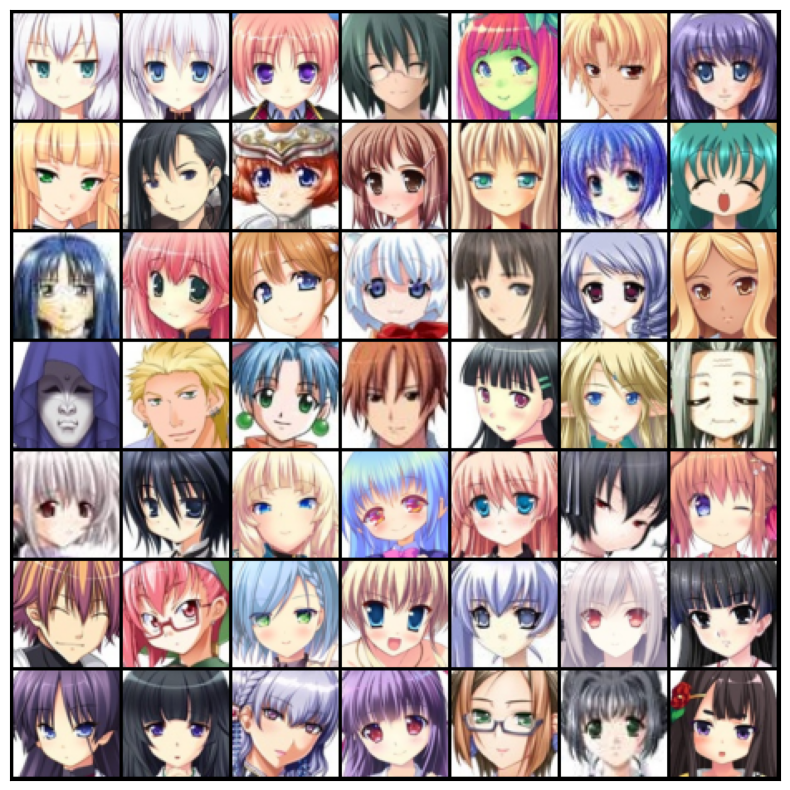

In [6]:
show_batch(train_dataset)

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_dataset, device)

In [10]:
class VAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=64):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),           # [B, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),          # [B, 128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),         # [B, 256, 4, 4]
            nn.ReLU(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 256, 4, 4)
        return self.decoder(x)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    # Use MSE loss instead of binary cross-entropy for reconstruction
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kld_loss

In [15]:
def save_images(images, epoch, file_path):
    torchvision.utils.save_image(images, file_path)

def show_images(images):
    grid_img = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Training function
def train(model, traindl, epochs, optimizer, sample_dir="samples"):
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in traindl:
            images = images.to(device)
            
            optimizer.zero_grad()
            recon_images, mu, logvar = model(images)
            loss = vae_loss(recon_images, images, mu, logvar)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(traindl.dl.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        
        # Save and display images
        if epoch == 0 or epoch == epochs - 1:
            with torch.no_grad():
                z = torch.randn(64, model.fc_mu.out_features).to(device)
                generated_images = model.decode(z)
                save_images(generated_images, epoch + 1, os.path.join(sample_dir, f"generated_epoch_{epoch+1}.png"))
                show_images(generated_images.cpu())

    return model

Epoch [1/20], Loss: 1838.0104


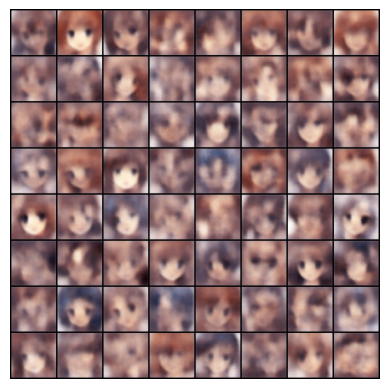

Epoch [2/20], Loss: 1076.3622
Epoch [3/20], Loss: 941.7583
Epoch [4/20], Loss: 871.9276
Epoch [5/20], Loss: 817.0923
Epoch [6/20], Loss: 789.5002
Epoch [7/20], Loss: 769.6221
Epoch [8/20], Loss: 756.0980
Epoch [9/20], Loss: 746.6400
Epoch [10/20], Loss: 737.6853
Epoch [11/20], Loss: 732.2310
Epoch [12/20], Loss: 724.7872
Epoch [13/20], Loss: 719.3933
Epoch [14/20], Loss: 715.3376
Epoch [15/20], Loss: 711.3092
Epoch [16/20], Loss: 708.7625
Epoch [17/20], Loss: 705.8435
Epoch [18/20], Loss: 702.4616
Epoch [19/20], Loss: 699.9246
Epoch [20/20], Loss: 696.7549


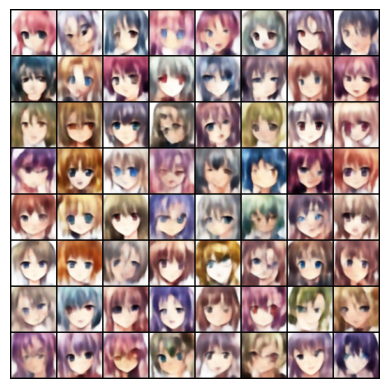

In [16]:
vae = VAE(in_channels=3, latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Train the model
trained_vae = train(vae, train_dl, epochs=20, optimizer=optimizer, sample_dir="vae_samples")

In [ ]:
for images, _ in train_dl:
    print(images.min(), images.max())  # Should print values between 0 and 1
    break